# Compile the main simulator code using cython 

In [3]:
!python setup.py build_ext --inplace

posix.uname_result(sysname='Linux', nodename='jyotika-XPS-15-9510', release='5.15.0-86-generic', version='#96~20.04.1-Ubuntu SMP Thu Sep 21 13:23:37 UTC 2023', machine='x86_64')
running build_ext
running build_ext


# Import all the relevant files 

In [1]:
# Import the pipeline creation object
import pandas as pd
import numpy as np
import cbgt as cbgt
import pipeline_creation as pl_creat
import plotting_functions as plt_func
import plotting_helper_functions as plt_help
import postprocessing_helpers as post_help


import importlib

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Choose the experiment and create the main pipeline

In [3]:
#Choose the experiment:
experiment_choice = 'n-choice'

if experiment_choice == 'stop-signal':
    import paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import paramfile_nchoice as paramfile
    
number_of_choices = 2
# Call choose_pipeline with the pipeline object
pl_creat.choose_pipeline(experiment_choice)

#Create the main pipeline
pl = pl_creat.create_main_pipeline(runloop=True)

# how many simulations do you want to run ? each simulation is executed as a seperate thread

num_sims = 1

num_cores = 7
# set a seed
import time
np.random.seed(int(time.time()))
#seed = np.random.choice(np.random.randint(0,9999999,100),1)[0]
seed = 8867366
print(seed)


in choose pipeline
in reward pipeline
8867366


In [4]:

# Define the data and figure directory

data_dir = "./Data/"
figure_dir = "./Figures/"


# Modify cellular parameters as desired

In [5]:
# list out the available parameter dictionaries
dir(paramfile)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'basestim',
 'celldefaults',
 'd1defaults',
 'd2defaults',
 'dpmndefaults',
 'np',
 'pd',
 'popspecific',
 'receptordefaults']

In [6]:
# view (or edit) one of the parameter dictionaries
paramfile.celldefaults

{'N': 75,
 'C': 0.5,
 'Taum': 20,
 'RestPot': -70,
 'ResetPot': -55,
 'Threshold': -50,
 'RestPot_ca': -85,
 'Alpha_ca': 0.5,
 'Tau_ca': 80,
 'Eff_ca': 0.0,
 'tauhm': 20,
 'tauhp': 100,
 'V_h': -60,
 'V_T': 120,
 'g_T': 0,
 'g_adr_max': 0,
 'Vadr_h': -100,
 'Vadr_s': 10,
 'ADRRevPot': -90,
 'g_k_max': 0,
 'Vk_h': -34,
 'Vk_s': 6.5,
 'tau_k_max': 8,
 'n_k': 0,
 'h': 1}

# Running the pipeline

### 1. Default values of environment variable

In [11]:
#See init_params.py / generateepochs.py / popconstruct.py / qvalues.py
#to know the parameters contained in each of the following variables 
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None, # default = 600ms
    'thalamic_threshold': None, # default 30sp/s
    'movement_time':None,# #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout':None, #wait for a choice to be made, default 1000, 
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'channels' : pd.DataFrame([["left"],["right"]], columns=['action']), #action channels related parameters (init_params.py)
    'number_of_choices':number_of_choices,
    #'actionchannels' : pd.DataFrame([[1],[2]], columns=['action']), #labels for the actions (init_params.py)
    #'actionchannels' : pd.DataFrame([["left"],["right"]], columns=['action']), #labels for the actions (init_params.py)
    'newpathways' :[['Cx', 'dSPN', 'AMPA', 'syn', 1, 0.016, True],['GPe', 'FSI', 'GABA', 'all', 1, 0.1, False]],
    'Q_support_params': None,#pd.DataFrame([[85,0.6]],columns=['dpmn_CPP_scale','q_alpha']), #initialization of Q-values update (qvalues.py) 
    'Q_df_set':pd.DataFrame([[0.5, 0.5]],columns=["left","right"]), #initialized Q-values df (qvalues.py)  
    'n_trials': 2, #number of trials (generateepochs.py)
    'volatility': [2,"exact"], #frequency of changepoints and type of change points (exact or poisson) (generateepochs.py)
    'conflict': (0.7, 0.3), #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.01, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 0.8, # 3 instead? how much stimulus the LIP gets at maximum
    'corticostriatal_plasticity_present':True, # whether plasticity is on or "off" at corticostriatal synapses
    'record_variables':["weight","optogenetic_input"],#"optogenetic_input"],
    'opt_signal_present':[False],
    'opt_signal_probability':[[1]], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude':[-0.5], # ampitude of the stop signal over base line
    'opt_signal_onset':[10.], # in ms
    'opt_signal_duration':["phase 0"],
    'opt_signal_channel': ["all"], # "all" (all channels are given the stop signal) 
    'opt_signal_population':["dSPN"],
    'sustainedfraction':0.7
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signal
    
}


### Run the simulation - 1 thread with the environment variable

In [12]:
# pd.DataFrame([['Cx', 'dSPN', 'AMPA', 'syn', 1, 0.016, True],['GPe', 'FSI', 'GABA', 'all', 1, 0.1, False]],columns=['src', 'dest', 'receptor', 'type', 'con', 'eff', 'plastic'])

In [13]:
# pd.DataFrame([['Cx', 'dSPN', 'AMPA', 'syn', 1, 0.27, True],['dSPN', 'GPe', 'GABA', 'syn', 1, 2.09, False]],columns=['src', 'dest', 'receptor', 'type', 'con', 'eff', 'plastic'])

In [ ]:
results = cbgt.ExecutionManager(cores=num_cores).run([pl]*num_sims,[configuration]*num_sims)


In [11]:
# List all the agent variables accessible
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'corticostriatal_plasticity_present', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'sustainedfraction', 'par', 'popconstruct', 'interface', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', 'd2defaults', 'popdata', 'pathways', 'opt_df', 'opt_channels_dfs', 'opt_amplitude_dfs', 'opt_onset_dfs', 'opt_duration_dfs', 'opt_populations_df

In [12]:
# pd.concat([results[0]['pathways'],pd.DataFrame(results[0]['newpathways'].iloc[0]).transpose()]).reset_index()

In [13]:
# pd.DataFrame(results[0]['newpathways'].iloc[0]).transpose()
results[0]['pathways']

,index,src,dest,receptor,type,con,eff,plastic,biselector
0,0`,Cx`,dSPN`,AMPA`,syn`,1.0`,0.016`,True`,<function MatchBiselector.<locals>.Biselector ...
1,1`,Cx`,dSPN`,NMDA`,syn`,1.0`,0.02`,False`,<function MatchBiselector.<locals>.Biselector ...
2,2`,Cx`,iSPN`,AMPA`,syn`,1.0`,0.015`,True`,<function MatchBiselector.<locals>.Biselector ...
3,3`,Cx`,iSPN`,NMDA`,syn`,1.0`,0.02`,False`,<function MatchBiselector.<locals>.Biselector ...
4,4`,Cx`,FSI`,AMPA`,all`,1.0`,0.19`,False`,<function MatchBiselector.<locals>.Biselector ...
5,5`,Cx`,Th`,AMPA`,syn`,1.0`,0.025`,False`,<function MatchBiselector.<locals>.Biselector ...
6,6`,Cx`,Th`,NMDA`,syn`,1.0`,0.029`,False`,<function MatchBiselector.<locals>.Biselector ...
7,7`,dSPN`,dSPN`,GABA`,syn`,0.45`,0.28`,False`,<function MatchBiselector.<locals>.Biselector ...
8,8`,dSPN`,iSPN`,GABA`,syn`,0.45`,0.28`,False`,<function MatchBiselector.<locals>.Biselector ...
9,9`,dSPN`,GPi`,GABA`,syn`,1.0`,2.09`,False`,<function MatchBiselector.<locals>.Biselector ...


In [14]:
results[0]['conflict']

(0.7, 0.3)

In [15]:
results[0]['Q_df']

,left,right
0,0.500000,0.5
0,0.450000,0.5
0,0.504849,0.5
0,0.454364,0.5


In [16]:
experiment_choice

'n-choice'

In [17]:
#Extract all the relevant dataframes
firing_rates, reward_q_df, performance, rt_dist, total_performance = plt_help.extract_relevant_frames(results,seed,experiment_choice)

/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = Q_df_local.append(rew_df)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(chosen_action)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(block)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append({'%_rewarded_actio

In [18]:
results[0]['popfreqs']

,GPi_left,GPi_right,STN_left,STN_right,GPe_left,GPe_right,dSPN_left,dSPN_right,iSPN_left,iSPN_right,Cx_left,Cx_right,Th_left,Th_right,FSI_common,CxI_common,Time (ms)
0,48.888889,52.000000,30.355556,28.844444,50.444444,54.155556,15.111111,13.555556,16.000000,15.555556,0.000000,0.000000,15.111111,16.000000,0.0,1.075269,0
1,48.888889,52.000000,30.533333,28.866667,49.844444,53.244444,15.111111,13.777778,16.666667,16.888889,0.000000,0.000000,15.555556,16.444444,0.0,1.075269,1
2,48.888889,51.333333,30.355556,28.733333,49.422222,52.422222,15.555556,14.000000,17.111111,17.333333,0.000000,0.000000,15.555556,17.111111,0.0,1.075269,2
3,48.888889,51.111111,30.577778,29.244444,49.044444,51.355556,16.000000,13.777778,16.888889,18.222222,0.000000,0.000000,15.777778,17.333333,0.0,1.075269,3
4,48.000000,51.111111,30.866667,29.600000,49.933333,50.400000,15.555556,14.666667,16.666667,18.222222,0.000000,0.000000,16.000000,17.555556,0.0,1.075269,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,25.555556,24.888889,31.933333,36.333333,45.288889,40.933333,25.111111,25.333333,26.444444,26.222222,2.042484,0.980392,30.888889,32.888889,0.0,1.881720,2624
2625,26.444444,25.111111,32.288889,36.244444,43.844444,42.444444,25.111111,25.333333,26.888889,25.777778,2.042484,0.980392,31.111111,33.333333,0.0,1.881720,2625
2626,26.888889,25.111111,32.733333,35.822222,42.466667,43.933333,24.888889,25.333333,26.666667,25.777778,2.042484,0.980392,32.444444,33.777778,0.0,1.881720,2626
2627,28.222222,24.222222,33.133333,35.555556,41.822222,44.666667,24.222222,25.555556,26.888889,25.777778,1.879085,1.062092,32.666667,34.000000,0.0,1.971326,2627


In [19]:
# firing rates  
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed,n_trials,volatility,volatility_type,conflict
0,0,GPi_left,48.888889,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
1,1,GPi_left,48.888889,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
2,2,GPi_left,48.888889,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
3,3,GPi_left,48.888889,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
4,4,GPi_left,48.000000,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
...,...,...,...,...,...,...,...,...,...,...
42059,2624,CxI_common,1.881720,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"
42060,2625,CxI_common,1.881720,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"
42061,2626,CxI_common,1.881720,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"
42062,2627,CxI_common,1.971326,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"


In [20]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,50.0,66.666667,left,left,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,0.0,33.333333,left,right,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [21]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)


['left' 'right']
nuc_list ['dSPN-left' 'iSPN-left' 'dSPN-right' 'iSPN-right']
ind_list [[0 0 1 0]
 [0 1 1 1]]


/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)


In [22]:
recorded_variables['weight']

,weights,trials,nuclei,seed
0,0.006465,0,dSPN-left,8867366_0
1,0.039109,1,dSPN-left,8867366_0
0,0.028065,0,iSPN-left,8867366_0
1,0.016502,1,iSPN-left,8867366_0
0,0.014029,0,dSPN-right,8867366_0
1,0.041004,1,dSPN-right,8867366_0
0,0.022950,0,iSPN-right,8867366_0
1,0.026191,1,iSPN-right,8867366_0


In [23]:
# recorded_variables['optogenetic_input']

<AxesSubplot:xlabel='trials', ylabel='weights'>

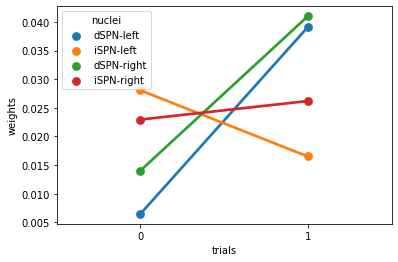

In [24]:
import seaborn as sns
import pylab as pl
sns.pointplot(x="trials",y="weights",hue="nuclei",data=recorded_variables['weight'])


<AxesSubplot:xlabel='Time(ms)', ylabel='value'>

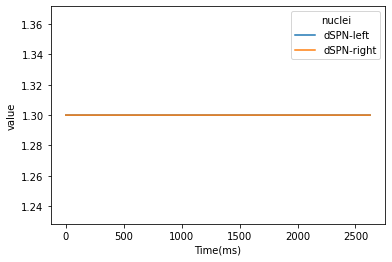

In [25]:
pl.figure()
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['optogenetic_input'],hue='nuclei')

In [26]:
# Relevant reward_dataframe
reward_q_df[0]

,level_0,index,Trials,variable,value,data_type,seed,n_trials,volatility,volatility_type,conflict,condition
0,0,4,0,left,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,1,5,1,left,0.450000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
2,2,6,2,left,0.504849,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
3,3,7,3,left,0.454364,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
4,4,8,0,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
5,5,9,1,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
6,6,10,2,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
7,7,11,3,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
8,0,0,0,left,0.000000,reward_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
9,1,1,1,left,0.998486,reward_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [27]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,50.0,66.666667,left,left,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,0.0,33.333333,left,right,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [28]:
# Extract the data tables from the agent
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]["decisiondurationplusdelay"]-datatables[0]["decisionduration"]

0    254
1    252
2    252
dtype: object

In [29]:
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,left,0,65,65,319,319,left,0.0
1,left,920,921,1,253,1173,left,1.0
2,left,1774,1775,1,253,2027,right,0.0


In [30]:
# Check the Q-values data frame
results[0]['Q_df']

,left,right
0,0.500000,0.5
0,0.450000,0.5
0,0.504849,0.5
0,0.454364,0.5


In [31]:
# postfix = "weak_GPi_inh"
postfix = ""

In [32]:
#Save the selected variables of results in the data_dir specified
cbgt.saveResults(results,data_dir+'network_data_'+postfix+'_'+str(seed)+'.pickle',['popfreqs','popdata','Q_support_params','d1','d2','dpmns','datatables'])


In [33]:
firing_rates[0].to_csv(data_dir+"firing_rates_"+postfix+".csv")
reward_q_df[0].to_csv(data_dir+"reward_df_"+postfix+".csv")
performance.to_csv(data_dir+"performance_"+postfix+".csv")
rt_dist.to_csv(data_dir+"rt_dist_"+postfix+".csv")
total_performance.to_csv(data_dir+"total_performance_"+postfix+".csv")

In [34]:
reward_q_df

[    level_0  index  Trials variable     value      data_type       seed  \
 0         0      4       0     left  0.500000           Q_df  8867366_0   
 1         1      5       1     left  0.450000           Q_df  8867366_0   
 2         2      6       2     left  0.504849           Q_df  8867366_0   
 3         3      7       3     left  0.454364           Q_df  8867366_0   
 4         4      8       0    right  0.500000           Q_df  8867366_0   
 5         5      9       1    right  0.500000           Q_df  8867366_0   
 6         6     10       2    right  0.500000           Q_df  8867366_0   
 7         7     11       3    right  0.500000           Q_df  8867366_0   
 8         0      0       0     left  0.000000      reward_df  8867366_0   
 9         1      1       1     left  0.998486      reward_df  8867366_0   
 10        2      2       2     left  0.000000      reward_df  8867366_0   
 11        3      3       0    right  0.000000      reward_df  8867366_0   
 12        4

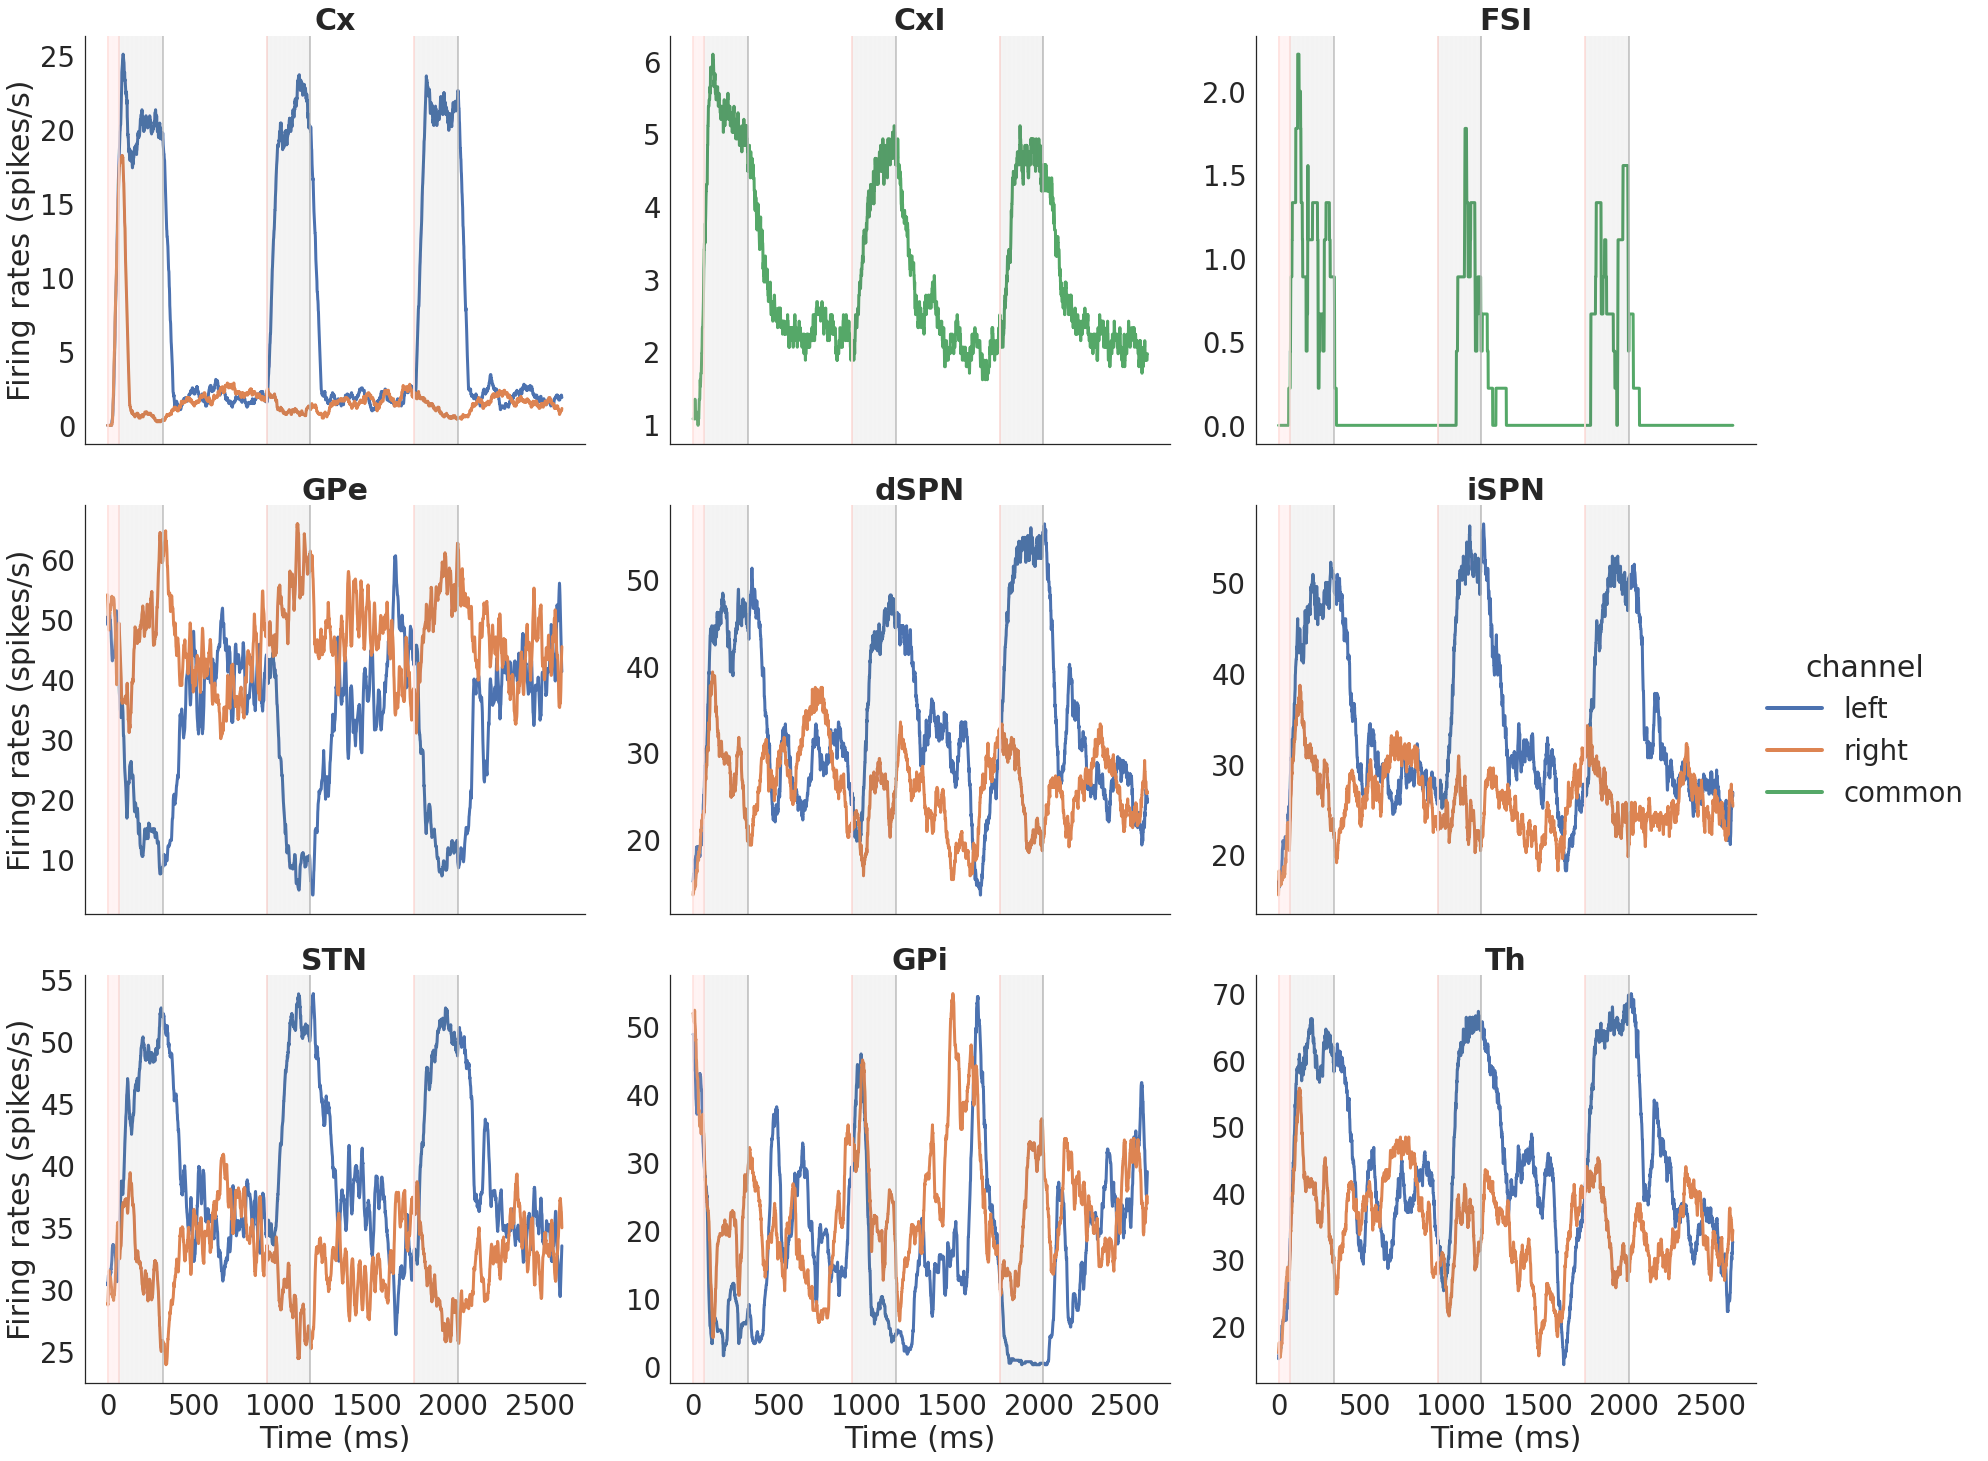

In [35]:
# Plot the firing rates extracted, figure handles are returned in fig_handles

FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_new_pathways_"+postfix+".png",dpi=400)

In [ ]:
# FR_fig_handles_zoom = plt_func.plot_fr_flex(firing_rates[0],datatables[0],['all'], [], (0, 500)) 

In [ ]:
reward_fig_handles = plt_func.plot_reward_Q_df(reward_q_df)